In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  
import urllib.parse as urlparse
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
import os
import pickle
import timeit
import random

import warnings
warnings.filterwarnings('ignore')

## 1. Import Data

In [2]:
# import reviews data
df_reviews = pd.read_csv("processed_data/processed_reviews.csv")
df_reviews = df_reviews.rename(columns={'score': 'rating'})
df_reviews.shape

(75921, 7)

In [3]:
df_reviews.head(5)

,uid,profile,anime_uid,text,rating,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,10046,eneri,2904,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '9', 'Animation': '...",https://myanimelist.net/reviews.php?id=10046


In [4]:
# create a userid for each profile
user_id_profile = df_reviews.drop_duplicates(['profile'])
user_id_profile['user_id'] = user_id_profile.index
user_id_profile.shape

(15363, 8)

In [5]:
# merge user_id_profile with df_reviews to get user_id
df_reviews = df_reviews.merge(user_id_profile[['profile', 'user_id']], how='left', on='profile')
df_reviews.shape

(75921, 8)

In [6]:
# check number of unique animes
len(set(df_reviews['anime_uid'].tolist()))

2913

In [8]:
# import animes data
df_anime = pd.read_csv('processed_data/processed_anime.csv')
df_anime = df_anime.rename(columns={'Score': 'Average_rating'})
df_anime.shape

(4808, 92)

## 2. Apply Train Test Split

Apply the leave-one-out methodology to do train-test split. For each user, the most recent review is used as the test set. The most recent review is indicated by the larger uid. The reamining ratings would be used in the train dataset. This will help to ensure no data leakage.

In [9]:
try:
    os.mkdir('./processed_data/autoencoder/')
except OSError:
    pass

In [10]:
# create test dataset
test = df_reviews.loc[df_reviews.groupby('user_id')['uid'].idxmax()]
test.shape

(15363, 8)

In [11]:
# create train dataset
train = df_reviews[~(df_reviews['uid'].isin(test['uid'].tolist()))]
train.shape

(60558, 8)

In [12]:
# check which are the animes present in test but not in train
animes_not_in_train = list(set(test[~(test['anime_uid'].isin(train['anime_uid']))]['anime_uid'].tolist()))
len(animes_not_in_train)

121

## 3. Train Autoencoder using Train Dataset only

**a. prepare dataset**

In [13]:
# check min review score
min(train['rating'])

0

In [14]:
# adjust the min rating to 0.1 to distinguish between those poorly rated items and those items rated 0
train['rating'] = np.where(train['rating']==0, 0.1, train['rating'])

In [15]:
# check min review score
min(train['rating'])

0.1

In [16]:
# get unique list of animes
anime_uid = list(set(train['anime_uid'].tolist()))
len(anime_uid)

2792

In [17]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = train.pivot(index   = 'user_id', 
                                 columns = 'anime_uid', 
                                 values  = 'rating').fillna(0)
users_items_matrix_df.head(10)

anime_uid,1,6,7,8,15,16,17,18,19,20,...,39699,39701,39799,39811,39940,39959,39963,40004,40040,40197
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
users_items_matrix_df.shape

(15363, 2792)

In [19]:
# very sparse matrix
users_items_matrix_df.values.mean()*100

1.0336814234027463

In [20]:
# create a dataframe with columns being
# the name of each of the animes not in train and each row refers to each user with rating = 0
manual_df = pd.DataFrame(0, columns = animes_not_in_train, index=users_items_matrix_df.index)
print(manual_df.shape)
manual_df.head()

(15363, 121)


,3077,34309,38923,2574,2087,3112,33835,28207,2609,3637,...,4061,37345,4062,6116,485,32230,27629,7152,13307,511
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# combine the manually created dataframe to the sparse matrix
users_items_matrix_df = pd.concat([users_items_matrix_df, manual_df], axis=1)
users_items_matrix_df.shape

(15363, 2913)

**b. Build autoencoder model**

In [22]:
def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc1 = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc1)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec1 = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec1) 
    # the output target is continuous score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [23]:
# input
# input x
X = users_items_matrix_df.values
y = users_items_matrix_df.values
print(X.shape)
print(y.shape)

(15363, 2913)
(15363, 2913)


In [24]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 2913)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1491968   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 2913)              1494369   
Total params: 3,249,249
Trainable params: 3,249,249
Non-trainable params: 0
___________________________________________________

In [25]:
hist = model.fit(x=X, y=y,
                  epochs=30,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.2)

Epoch 1/30
193/193 [==============================] - 2s 4ms/step - loss: 0.1922 - val_loss: 0.0396
Epoch 2/30
193/193 [==============================] - 1s 3ms/step - loss: 0.1129 - val_loss: 0.0326
Epoch 3/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0932 - val_loss: 0.0301
Epoch 4/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0869 - val_loss: 0.0290
Epoch 5/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0814 - val_loss: 0.0284
Epoch 6/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0790 - val_loss: 0.0280
Epoch 7/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0758 - val_loss: 0.0278
Epoch 8/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0743 - val_loss: 0.0276
Epoch 9/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0725 - val_loss: 0.0274
Epoch 10/30
193/193 [==============================] - 1s 3ms/step - loss: 0.0699 - val_loss: 0.0273

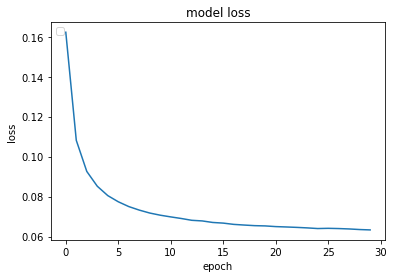

In [26]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

## 4. Predict Ratings on Animes which Users did not Interact Before

In [27]:
# Predict new Matrix Interactions
# set score zero on predicted anime
# because we only want to predict the scores of those anime that users did not interact before

new_matrix = model.predict(X) * (X == 0)

In [28]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
print(new_users_items_matrix_df.shape)

(15363, 2913)


In [29]:
# check predictions
new_users_items_matrix_df.head()

,1,6,7,8,15,16,17,18,19,20,...,4061,37345,4062,6116,485,32230,27629,7152,13307,511
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.815754,0.007944,0.131963,0.000000,-0.071079,0.648736,0.074269,-0.065678,0.000000,0.343855,...,-0.060295,-0.169714,-0.045879,-0.017517,-0.036187,0.161904,0.125280,-0.119060,-0.186030,-0.005535
1,0.303530,0.563738,0.047009,-0.026770,0.012784,-0.004483,-0.035429,-0.032839,0.760301,0.075650,...,-0.022120,-0.059445,-0.058280,0.029179,-0.001597,-0.008781,0.075093,0.035789,-0.015432,-0.018780
2,-0.092296,-0.114557,-0.012189,0.022446,-0.055207,-0.085420,0.027564,0.000272,0.303190,0.086033,...,-0.010020,0.000270,0.015533,-0.010393,0.015257,0.002791,0.011026,0.011531,-0.016637,0.011895
3,0.139117,-0.059430,-0.099219,-0.023956,0.069304,-0.146089,-0.028173,0.023907,0.005598,0.209523,...,0.009128,0.014803,-0.012119,-0.003019,0.002855,0.016726,-0.015920,0.006949,-0.042908,-0.031106
4,0.036470,-0.369006,-0.052915,-0.027892,0.067990,-0.053043,0.059314,-0.002268,-0.016319,0.137118,...,0.021964,-0.002817,-0.012478,0.015654,-0.007954,0.013470,0.007904,-0.003435,-0.006032,-0.005468


## 5. Evaluate Hit Rate @ 10

In [30]:
# get unique user_id
user_ids = user_id_profile['user_id'].tolist()
len(user_ids)

15363

In [31]:
# get unique list of animes
anime_uid = list(set(df_reviews['anime_uid'].tolist()))
len(anime_uid)

2913

In [32]:
# identify list of animes not watched. As the not watched list is huge, 
# we randomly sample 99 animes not watched items + the one watched item in the test data to form the not watched list

not_watched_list_1 = []
not_watched_list_2 = []
not_watched_list_3 = []
not_watched_list_4 = []
not_watched_list_5 = []

for user in user_ids:
    
    # subset watched animes - i.e. those with ratings
    u_watched = train[train['user_id']==user]['anime_uid'].tolist()
    
    # identify animes not watched i.e. those without ratings
    u_not_watched = list(set(anime_uid) - set(u_watched) - set(test[test['user_id']==user]['anime_uid'].tolist()))
    
    # set seed to control reproducibility of sampling
    random.seed(2345)
    u_not_watched_1 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_1.append(u_not_watched_1)
        
    random.seed(2346)
    u_not_watched_2 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_2.append(u_not_watched_2)
    
    random.seed(2347)
    u_not_watched_3 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_3.append(u_not_watched_3)
    
    random.seed(2348)
    u_not_watched_4 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_4.append(u_not_watched_4)
    
    random.seed(2349)
    u_not_watched_5 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_5.append(u_not_watched_5)


In [33]:
# check len of watched_list and not watched list
print(len(not_watched_list_1))
print(len(not_watched_list_5))

15363
15363


In [34]:
# check 
print(len(not_watched_list_1[0]))
print(len(not_watched_list_5[0]))

100
100


In [35]:
# create a function to fetch the predicted ratings for the anime which has not been watched by each user

def predict_ratings(prediction_matrix, profile, not_watched):
    
    '''
    Args:
        prediction_matrix - dataframe containing all the predicted ratings
        profile - list of unique user ids
        not_watched - list of not watched animes for all users
    
    Returns:
        predicted_rating - nested list of predicted ratings for each user

    '''
    
    # initialise list to store predictions
    predicted_rating = []
    
    for i in range(len(profile)):
        
        user = profile[i]
    
        # subset animes not watched for user
        animes = not_watched[i]
        #print(len(animes))
    
        # subset the dataframe to extract the predictions
        user_row = prediction_matrix[prediction_matrix.index == user][animes]
        pred_rating = user_row.values.flatten().tolist()

        predicted_rating.append(pred_rating) 
    
    return predicted_rating


In [36]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings_1 = predict_ratings(new_users_items_matrix_df, user_ids, not_watched_list_1)
print('done')
predicted_ratings_2 = predict_ratings(new_users_items_matrix_df, user_ids, not_watched_list_2)
print('done')
predicted_ratings_3 = predict_ratings(new_users_items_matrix_df, user_ids, not_watched_list_3)
print('done')
predicted_ratings_4 = predict_ratings(new_users_items_matrix_df, user_ids, not_watched_list_4)
print('done')
predicted_ratings_5 = predict_ratings(new_users_items_matrix_df, user_ids, not_watched_list_5)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 26.553325399999977


In [37]:
# create function to evaluate hit rate @ 10

def hit_rate(predictions, not_watched, test_dataset, profile):
    
    '''
    Args:
        predictions - nested list of predicted ratings of every user for the 100 animes randomly sampled
        not_watched - nested list of 100 animes not watched for each user
        test_dataset - test data
        profile - list of unique profiles
    
    Returns:
        hit_rate - hit rate @ 10
        top_10_animes - nested list of top 10 ainmes recommended for each user 
    '''
    
    top_10_animes = []
    hit = 0
    
    for i in range(len(predictions)):
    
        user = profile[i]
    
        # get the top 10 animes recommended to user
        top_10_idx = np.argsort(predictions[i])[-10:]
        top_10_animes = [not_watched[i][k] for k in top_10_idx]
    
        # check if the test data is found in the proposed top 10 recommended animes
        anime_watched = test_dataset[test_dataset['user_id']==user]['anime_uid']

        if anime_watched.values in top_10_animes:
            hit += 1
        else:
            hit = hit
    
    hit_rate = round((hit/len(profile))*100,2)
    
    return top_10_animes, hit_rate

In [38]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes_1, hit_rate_1 = hit_rate(predicted_ratings_1, not_watched_list_1, test, user_ids)
top_10_animes_2, hit_rate_2 = hit_rate(predicted_ratings_2, not_watched_list_2, test, user_ids)
top_10_animes_3, hit_rate_3 = hit_rate(predicted_ratings_3, not_watched_list_3, test, user_ids)
top_10_animes_4, hit_rate_4 = hit_rate(predicted_ratings_4, not_watched_list_4, test, user_ids)
top_10_animes_5, hit_rate_5 = hit_rate(predicted_ratings_5, not_watched_list_5, test, user_ids)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 18.056894


In [39]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate_5))


Hit Rate @ 10 based on not_watched_list_1: 41.91%
Hit Rate @ 10 based on not_watched_list_2: 42.22%
Hit Rate @ 10 based on not_watched_list_3: 42.09%
Hit Rate @ 10 based on not_watched_list_4: 43.42%
Hit Rate @ 10 based on not_watched_list_5: 45.23%


In [40]:
# print avg hit rates
avg_hit_rate = (hit_rate_1 + hit_rate_2 + hit_rate_3 + hit_rate_4 + hit_rate_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using Autoencoder model: {}%'.format(avg_hit_rate))


Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using Autoencoder model: 42.974%


In [43]:
# save the results
hit_rates_all = [hit_rate_1, hit_rate_2, hit_rate_3, hit_rate_4, hit_rate_5, avg_hit_rate]

with open("processed_data/autoencoder/model4_results.pkl", "wb") as fp:   
    pickle.dump((predicted_ratings_1, predicted_ratings_2, predicted_ratings_3, predicted_ratings_4, predicted_ratings_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes_1, top_10_animes_2, top_10_animes_3, top_10_animes_4, top_10_animes_5, hit_rates_all, user_ids), fp)